In [1]:
from random import randint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_similarity_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('data_clean.csv', converters={'Tags': pd.eval})

In [3]:
df.head()

,0,Tags
0,error implementation interface activity view v...,"[java, android]"
1,button size checkbox button checkbox png file ...,[android]
2,geting sorted edge point concave polygon set p...,[python]
3,vba loop store value string store value a1 a5 ...,"[vba, loops]"
4,refactored storyboard io read refactoring stor...,"[ios, swift]"


# I. Setup

## Inputs

In [4]:
X = df['0'].values.astype(str)

## Output

In [5]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tags'])

In [6]:
y.shape

(42764, 114)

In [7]:
mlb.classes_

array(['.htaccess', '.net', 'actionscript-3', 'ajax', 'algorithm',
       'amazon-web-services', 'android', 'angular', 'angularjs', 'apache',
       'api', 'arrays', 'asp.net', 'azure', 'bash', 'c', 'c#', 'c++',
       'c++11', 'class', 'codeigniter', 'cordova', 'css', 'css3',
       'database', 'date', 'datetime', 'delphi', 'django', 'eclipse',
       'email', 'entity-framework', 'excel', 'excel-vba', 'facebook',
       'file', 'flash', 'forms', 'function', 'git', 'google-chrome',
       'google-maps', 'hibernate', 'html', 'html5', 'http', 'image',
       'internet-explorer', 'ios', 'iphone', 'java', 'javascript',
       'jquery', 'json', 'jsp', 'laravel', 'linq', 'linux', 'list',
       'loops', 'macos', 'matlab', 'maven', 'mongodb', 'multithreading',
       'mysql', 'node.js', 'objective-c', 'oop', 'oracle', 'pandas',
       'performance', 'perl', 'php', 'postgresql', 'powershell', 'python',
       'qt', 'r', 'reactjs', 'regex', 'rest', 'ruby', 'ruby-on-rails',
       'scala', 'sele

## Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Scorer

In [9]:
jaccard_scorer = make_scorer(jaccard_similarity_score)

# II. Supervised learning

## 1. Logistic Regression

### Custom Classifier with probability threshold

In [10]:
class CustomOVRClassifier(OneVsRestClassifier):
    
    def __init__(self, estimator=LogisticRegression(), threshold=.1, **kwargs):
        self.threshold = threshold
        super(CustomOVRClassifier, self).__init__(estimator=estimator, **kwargs)
        
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.where(probas >= self.threshold, 1, 0)

### Pipeline

In [11]:
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', CustomOVRClassifier(estimator=LogisticRegression()))
])

In [12]:
pipe.get_params()

{'clf': CustomOVRClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
           threshold=0.1),
 'clf__estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'clf__estimator__C': 1.0,
 'clf__estimator__class_weight': None,
 'clf__estimator__dual': False,
 'clf__estimator__fit_intercept': True,
 'clf__estimator__intercept_scaling': 1,
 'clf__estimator__max_iter': 100,
 'clf__estimator__multi_class': 'ovr',
 'clf__estimator__n_jobs': 1,
 'clf__estimator__penalty': 'l2',
 'clf__estimator__random_state': None,
 'clf__estimator__solve

### Cross Validation

In [13]:
param_grid = dict(vect__max_features=[1000, 5000, 10000, 20000],
                  vect__ngram_range=[(1,1), (1,2), (1,3)],
                  clf__estimator__penalty=['l1', 'l2'],
                  clf__estimator__C=[1, 10, 100],
                  clf__threshold=[.1, .15, .2, .25])

cv = GridSearchCV(pipe, param_grid=param_grid, scoring=jaccard_scorer, cv=3, verbose=3)
cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.4183022955074213, total=  20.6s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s


[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.41823815611113335, total=   9.4s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.9s remaining:    0.0s


[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.4303149957017696, total=   9.4s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.41672323405089273, total=  12.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.4202570252682497, total=  12.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 2), 

[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.46587516869997464, total=  17.4s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.4670162041058122, total=  17.3s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.45848024521441416, total=  21.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=

[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.4989463767922285, total=  14.8s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.48859343194765503, total=  18.5s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.49296407896866223, total=  18.5s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram

[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.48487089719434684, total=  17.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.48947167399370184, total=  17.1s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.49836355456970927, total=  17.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 

[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.4413157929900985, total=  16.0s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.4577559674136234, total=  16.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1, 1), score=0.4790486880375572, total=  10.3s
[CV] clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1

[CV]  clf__estimator__C=1, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.48930319672532746, total=  21.0s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.41052650723869505, total=  11.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.4107349231589246, total=  11.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=1000, vect__ngram_range=(1, 1

[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 1), score=0.4413349828441962, total=  15.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 1), score=0.4493275385170437, total=  15.1s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.43834544855263213, total=  19.6s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(

[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 1), score=0.4697970255354972, total=  14.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.45883108177327614, total=  18.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.46019727318483283, total=  18.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=10000, vect__ngram

[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.44694001630209657, total=  16.9s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.44957240402474713, total=  16.7s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.4592688108823175, total=  16.8s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 3),

[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.41412759285736556, total=  13.8s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.4252473152763116, total=  13.9s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.41320781609809765, total=  17.8s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=

[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.4168764559420251, total=  19.2s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.40329404795310697, total=  23.1s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.40413075528593256, total=  23.1s
[CV] clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=1, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram

[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.4415216849063074, total=  33.4s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.44256276232938846, total=  33.9s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.44868488255215405, total=  34.0s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=20000, vect__ngram

[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.4398431108794966, total=  34.9s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.4489921429239547, total=  35.0s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 1), score=0.45637630227472153, total=  26.3s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=10000, vect__ng

[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.4213078646480573, total=  41.2s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 1), score=0.45539661753767074, total=  27.6s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 1), score=0.4534498309659661, total=  27.8s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=5000, vect__ngram_range=(

[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.42260319835850657, total=  33.9s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.4249295505936606, total=  35.0s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.43012391375032855, total=  34.8s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000, vect__ngram

[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 1), score=0.47561878927981255, total= 1.0min
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 1), score=0.47853635233908354, total= 1.4min
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.4795286199785311, total=  31.7s
[CV] clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=20000, vect

[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 1), score=0.4654617145707783, total=  20.1s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.46175154001362967, total=  24.5s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.4637702978176273, total=  24.3s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=10000, vect__ngram_

[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.4722952327502884, total=  23.0s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.4749893101006187, total=  22.8s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.48184454213824707, total=  23.0s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=5000, vect__ngram_

[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.4454619150063916, total=  18.8s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.44962518540294233, total=  18.6s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.44041917767949007, total=  22.9s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=

[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.4981243680710522, total=  26.9s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.4821400733148933, total=  30.7s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.4866233725741723, total=  30.4s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_r

[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.47753161315035786, total=  28.9s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.4801471865521066, total=  28.4s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.4881872157711649, total=  28.5s
[CV] clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=10, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=20000, vect_

[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.4054599032267164, total= 1.1min
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.4133328656502354, total= 1.1min
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 1), score=0.4272025646850266, total=  48.8s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.1, vect__max_features=10000, vect__ngr

[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.358657127956071, total= 2.1min
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 1), score=0.4073408497363226, total=  59.8s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 1), score=0.4079087810099876, total=  59.4s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.15, vect__max_features=5000, vect__n

[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.3684900031219365, total= 1.9min
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.3729664322312344, total= 1.9min
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 1), score=0.37197602047709616, total= 2.0min
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=1000, vect__ngram_

[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 1), score=0.45284429270726156, total=  43.3s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 1), score=0.4557459322705792, total=  43.5s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.4699580421449283, total=  44.5s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.2, vect__max_features=20000, vect_

[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 1), score=0.43808224689807335, total=  47.9s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.4524764933566729, total=  47.6s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 2), score=0.45169345822699114, total=  47.4s
[CV] clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l1, clf__threshold=0.25, vect__max_features=1000

[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.42804550779249123, total=  30.8s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.4288351195048417, total=  30.8s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 2), score=0.43138227822541725, total=  30.9s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.1, vect__max_features=5000, vect__ngram

[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.3921578823903208, total=  28.0s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 2) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 2), score=0.39087290789423423, total=  27.8s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 3), score=0.38947423511542867, total=  31.6s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=1000, vect

[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000, vect__ngram_range=(1, 2), score=0.4872930502291647, total=  33.6s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.4757928342041147, total=  38.3s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000, vect__ngram_range=(1, 3), score=0.47754018734048664, total=  37.7s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.15, vect__max_features=20000

[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.4612300733594345, total=  37.2s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.4629147346900597, total=  36.3s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=10000, vect__ngram_range=(1, 3), score=0.4687701270761789, total=  36.6s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.2, vect__max_features=20000, vect__

[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.44083452481170193, total=  35.2s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1, 3) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=5000, vect__ngram_range=(1, 3), score=0.4489165341564556, total=  35.0s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 1), score=0.4522363046799489, total=  28.4s
[CV] clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, vect__ngram_range=(1, 1) 
[CV]  clf__estimator__C=100, clf__estimator__penalty=l2, clf__threshold=0.25, vect__max_features=10000, v

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 500.0min finished


{'clf__estimator__C': 1, 'clf__estimator__penalty': 'l1', 'clf__threshold': 0.15, 'vect__max_features': 10000, 'vect__ngram_range': (1, 3)}
0.4935280948867143


In [14]:
y_pred = cv.predict(X_test)
supervised_score = jaccard_similarity_score(y_test, y_pred)
print(f"Score: {supervised_score}")

pd.concat([pd.Series(mlb.inverse_transform(y_pred), name='y_pred'), 
           pd.Series(mlb.inverse_transform(y_test), name='y_true')], axis=1)

Score: 0.4998287389036617


,y_pred,y_true
0,"(python, r)","(r,)"
1,"(ios, xcode)","(macos,)"
2,"(css, html, javascript, jquery)","(html, xml)"
3,(),"(c#,)"
4,"(css, html, javascript)","(css,)"
5,"(asp.net, c#, visual-studio)","(asp.net, visual-studio)"
6,"(mysql, sql)","(mysql, php)"
7,"(xml,)","(sql, sql-server)"
8,(),"(r,)"
9,"(facebook, javascript)","(facebook,)"


### Results with best params

In [13]:
pipe.set_params(clf__threshold=0.15, clf__estimator__C=1, clf__estimator__penalty='l1',
                vect__max_features=10000, vect__ngram_range=(1,3))
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
supervised_score = jaccard_similarity_score(y_test, y_pred)
print(f"Score: {supervised_score}")

pd.concat([pd.Series(mlb.inverse_transform(y_pred), name='y_pred'), 
           pd.Series(mlb.inverse_transform(y_test), name='y_true')], axis=1)

Score: 0.5043737277906204


,y_pred,y_true
0,"(unit-testing,)","(maven, unit-testing)"
1,"(c#,)","(c#,)"
2,"(java,)","(java,)"
3,"(ios,)","(iphone, objective-c)"
4,(),"(validation,)"
5,"(angularjs, html5, java, spring)","(angularjs, spring)"
6,"(ios, iphone)","(ios,)"
7,"(c#, c++, visual-studio)","(c++,)"
8,"(delphi,)","(delphi,)"
9,"(c++, r)","(file, r)"


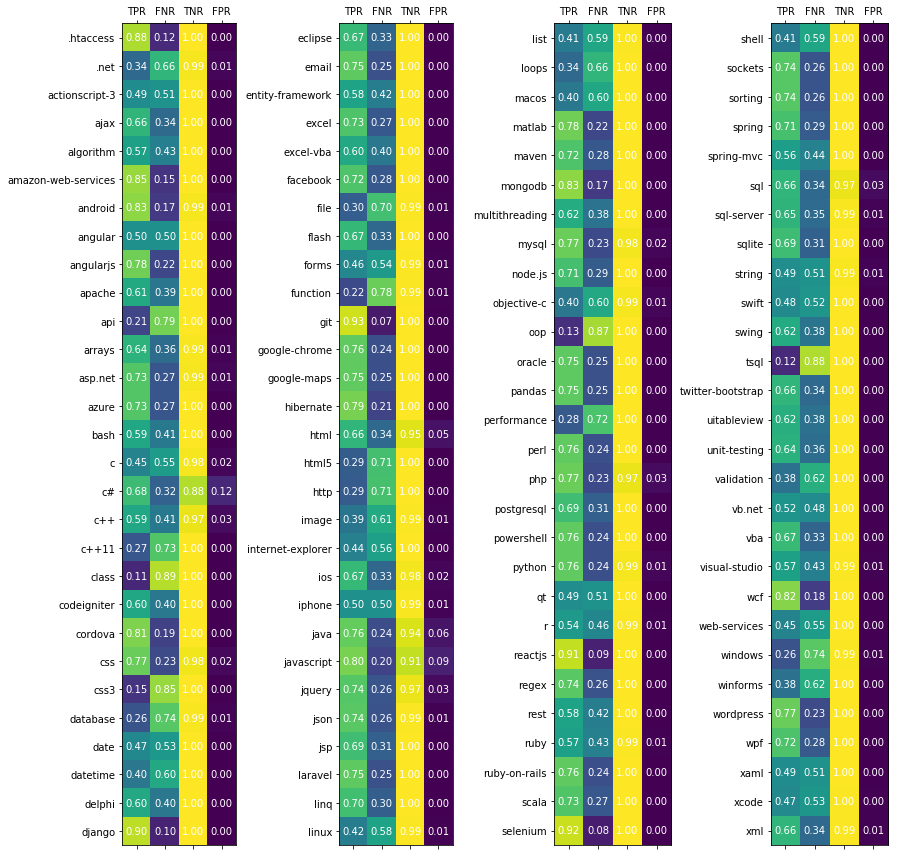

In [237]:
conf_matrix_multi = np.zeros((n_classes, 4))
for i in range(count):
    for c in range(n_classes):
        conf_matrix_multi[c,0] += 1 if y_test[i,c]==1 and y_pred[i,c]==1 else 0 # TPR: True Positive Rate
        conf_matrix_multi[c,1] += 1 if y_test[i,c]==1 and y_pred[i,c]==0 else 0 # FNR: False Negative Rate
        conf_matrix_multi[c,2] += 1 if y_test[i,c]==0 and y_pred[i,c]==0 else 0 # TNR: True Negative Rate
        conf_matrix_multi[c,3] += 1 if y_test[i,c]==0 and y_pred[i,c]==1 else 0 # FPR: False Positive Rate
conf_matrix_multi = [[m0/(m0+m1), m1/(m0+m1), m2/(m2+m3), m3/(m2+m3)] for m0,m1,m2,m3 in conf_matrix_multi]

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(141)
ax.matshow(mtx[:29])
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(29))
ax.set_xticklabels(['TPR','FNR','TNR','FPR'])
ax.set_yticklabels(mlb.classes_[:29])
for i in range(29):
    for j in range(4):
        text = ax.text(j, i, format(conf_matrix_multi[i][j], '.2f'),
                       ha="center", va="center", color="w")

ax2 = fig.add_subplot(142)
ax2.matshow(mtx[29:58])
ax2.set_xticks(np.arange(4))
ax2.set_yticks(np.arange(29))
ax2.set_xticklabels(['TPR','FNR','TNR','FPR'])
ax2.set_yticklabels(mlb.classes_[29:58])
for i in range(29):
    for j in range(4):
        text = ax2.text(j, i, format(conf_matrix_multi[i+29][j], '.2f'),
                       ha="center", va="center", color="w")

ax3 = fig.add_subplot(143)   
ax3.matshow(mtx[58:86])
ax3.set_xticks(np.arange(4))
ax3.set_yticks(np.arange(28))
ax3.set_xticklabels(['TPR','FNR','TNR','FPR'])
ax3.set_yticklabels(mlb.classes_[58:86])
for i in range(28):
    for j in range(4):
        text = ax3.text(j, i, format(conf_matrix_multi[i+58][j], '.2f'),
                       ha="center", va="center", color="w")

ax4 = fig.add_subplot(144)   
ax4.matshow(mtx[86:])
ax4.set_xticks(np.arange(4))
ax4.set_yticks(np.arange(28))
ax4.set_xticklabels(['TPR','FNR','TNR','FPR'])
ax4.set_yticklabels(mlb.classes_[86:])
for i in range(28):
    for j in range(4):
        text = ax4.text(j, i, format(conf_matrix_multi[i+86][j], '.2f'),
                       ha="center", va="center", color="w")

plt.tight_layout()
plt.subplots_adjust(left=0.05)
plt.show()

## 2. Random Forest

### Random Forest with TF

In [16]:
pipe2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

In [17]:
pipe2.set_params(vect__max_features=10000, vect__ngram_range=(1, 2),
                 clf__n_estimators=10)
pipe2.fit(X_train, y_train)

y_pred = pipe2.predict(X_test)
supervised_score = jaccard_similarity_score(y_test, y_pred)
print(f"Score: {supervised_score}")

pd.concat([pd.Series(mlb.inverse_transform(y_pred), name='y_pred'), 
           pd.Series(mlb.inverse_transform(y_test), name='y_true')], axis=1)

Score: 0.30323636703769524


,y_pred,y_true
0,(),"(r,)"
1,(),"(macos,)"
2,"(html,)","(html, xml)"
3,(),"(c#,)"
4,"(css,)","(css,)"
5,"(asp.net,)","(asp.net, visual-studio)"
6,(),"(mysql, php)"
7,(),"(sql, sql-server)"
8,(),"(r,)"
9,(),"(facebook,)"


### Random Forest with TF-IDF

In [18]:
pipe3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [19]:
pipe3.set_params(vect__max_features=10000, vect__ngram_range=(1, 2),
                 clf__n_estimators=10)
pipe3.fit(X_train, y_train)

y_pred = pipe3.predict(X_test)
supervised_score = jaccard_similarity_score(y_test, y_pred)
print(f"Score: {supervised_score}")

pd.concat([pd.Series(mlb.inverse_transform(y_pred), name='y_pred'), 
           pd.Series(mlb.inverse_transform(y_test), name='y_true')], axis=1)

Score: 0.30279518598197863


,y_pred,y_true
0,(),"(r,)"
1,(),"(macos,)"
2,"(html,)","(html, xml)"
3,"(android,)","(c#,)"
4,"(css,)","(css,)"
5,"(asp.net,)","(asp.net, visual-studio)"
6,"(mysql,)","(mysql, php)"
7,(),"(sql, sql-server)"
8,(),"(r,)"
9,"(facebook,)","(facebook,)"


### Custom random forest with probability threshold

In [238]:
class CustomRandomForestClassifier(RandomForestClassifier):
    
    def __init__(self, threshold=.1, **kwargs):
        self.threshold = threshold
        super(CustomRandomForestClassifier, self).__init__(**kwargs)
        
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.hstack((np.where(x[:,1]>=self.threshold, 1, 0).reshape(-1, 1) for x in probas))

In [239]:
pipe4 = Pipeline([
    ('vect', CountVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', CustomRandomForestClassifier())
])

### Cross validation with custom random forest

In [240]:
param_grid = dict(clf__threshold=[.1, .2, .3, .4, .5])

cv = GridSearchCV(pipe4, param_grid=param_grid, scoring=jaccard_scorer, cv=3, verbose=3)
cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__threshold=0.1 ..............................................
[CV] .... clf__threshold=0.1, score=0.18375860438763164, total= 1.9min
[CV] clf__threshold=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] ..... clf__threshold=0.1, score=0.1835156022640765, total=  23.0s
[CV] clf__threshold=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV] .... clf__threshold=0.1, score=0.18697851525585524, total=  23.0s
[CV] clf__threshold=0.2 ..............................................
[CV] .... clf__threshold=0.2, score=0.39646502101604525, total=  22.5s
[CV] clf__threshold=0.2 ..............................................
[CV] ..... clf__threshold=0.2, score=0.3979223735139926, total=  22.6s
[CV] clf__threshold=0.2 ..............................................
[CV] ..... clf__threshold=0.2, score=0.3980348030460274, total=  22.1s
[CV] clf__threshold=0.3 ..............................................
[CV] ..... clf__threshold=0.3, score=0.4453465531755683, total=  22.1s
[CV] clf__threshold=0.3 ..............................................
[CV] .... clf__threshold=0.3, score=0.43844956371848154, total=  21.8s
[CV] clf__threshold=0.3 ..............................................
[CV] .... clf__threshold=0.3, score=0.45301700139414103, total=  22.2s
[CV] clf__threshold=0.4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.1min finished


{'clf__threshold': 0.3}
0.4456043727627303


In [241]:
y_pred = cv.predict(X_test)
supervised_score = jaccard_similarity_score(y_test, y_pred)
print(f"Score: {supervised_score}")

pd.concat([pd.Series(mlb.inverse_transform(y_pred), name='y_pred'), 
           pd.Series(mlb.inverse_transform(y_test), name='y_true')], axis=1)

Score: 0.46337996801938436


,y_pred,y_true
0,"(unit-testing,)","(maven, unit-testing)"
1,"(java,)","(c#,)"
2,"(java,)","(java,)"
3,(),"(iphone, objective-c)"
4,"(c,)","(validation,)"
5,"(android, java, xml)","(angularjs, spring)"
6,"(.net, c#)","(ios,)"
7,"(c++,)","(c++,)"
8,"(delphi,)","(delphi,)"
9,(),"(file, r)"


# III. Unsupervised learning: LDA

### Helper functions

In [242]:
def print_top_words(model, feature_names, n_top_words):
    """ Print most common words for each topic after LDA """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}: ")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

In [243]:
def print_top_words_only_tags(model, feature_names, n_top_words):
    """ Print most common words that also are tags for each topic """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}: ")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]
               if feature_names[i] in mlb.classes_])
    print()

In [244]:
def keep_only_tags(data, model, feature_names, n_top_words, tags_list, threshold):
    """ 
    Return the list of tags that are present in each topic top words from LDA 
    if the topic distribution is greater than 'limit'
    """
    tags = []
    if type(data) == np.ndarray:
        output = model.transform(data.reshape(1, -1))
    else:
        output = model.transform(data.values.reshape(1, -1))
    for topic_idx, topic in enumerate(model.components_):
        if output[0, topic_idx] >= threshold:
            tags.extend([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]
                         if feature_names[i] in tags_list])
    return tags

### Input transformation

In [246]:
vect = CountVectorizer(max_features=10000, ngram_range=(1,3))
tf = vect.fit_transform(X_train)

### Custom LDA

In [247]:
class CustomLDA(LatentDirichletAllocation):
    
    def __init__(self, n_components=10, learning_decay=0.7, learning_offset=10., max_iter=10, 
                 num_top_words=30, threshold=0.2, **kwargs):
        self.n_components = n_components
        self.learning_decay = learning_decay
        self.learning_offset = learning_offset
        self.max_iter = max_iter
        self.num_top_words = num_top_words
        self.threshold = threshold
        super(CustomLDA, self).__init__(n_components=self.n_components, learning_method='online',
                                        learning_decay=self.learning_decay, learning_offset=self.learning_offset,
                                        max_iter=self.max_iter, **kwargs)
        
    def predict(self, X):
        y_pred = pd.DataFrame(X.toarray()).apply(
            lambda row: keep_only_tags(row, 
                                       self, vect.get_feature_names(), 
                                       self.num_top_words, mlb.classes_, self.threshold), axis=1)
        return mlb.transform(y_pred)

### Cross Validation

In [15]:
param_grid = dict(n_components=[10, 20, 30, 40],
                  learning_decay=[0.7, 0.9, 0.95])

cv = GridSearchCV(CustomLDA(), param_grid=param_grid, scoring=jaccard_scorer, cv=3, verbose=3)
cv.fit(tf, y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_decay=0.7, n_components=10 .............................
[CV]  learning_decay=0.7, n_components=10, score=0.06486623495651082, total= 3.9min
[CV] learning_decay=0.7, n_components=10 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.8min remaining:    0.0s


[CV]  learning_decay=0.7, n_components=10, score=0.06669694477110685, total= 4.0min
[CV] learning_decay=0.7, n_components=10 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 17.7min remaining:    0.0s


[CV]  learning_decay=0.7, n_components=10, score=0.06665167169357059, total= 3.9min
[CV] learning_decay=0.7, n_components=20 .............................
[CV]  learning_decay=0.7, n_components=20, score=0.07740306925094019, total= 4.1min
[CV] learning_decay=0.7, n_components=20 .............................
[CV]  learning_decay=0.7, n_components=20, score=0.05694601208351092, total= 4.1min
[CV] learning_decay=0.7, n_components=20 .............................
[CV]  learning_decay=0.7, n_components=20, score=0.05807359224612112, total= 4.1min
[CV] learning_decay=0.7, n_components=30 .............................
[CV]  learning_decay=0.7, n_components=30, score=0.06714458750283275, total= 4.3min
[CV] learning_decay=0.7, n_components=30 .............................
[CV]  learning_decay=0.7, n_components=30, score=0.05927363436717099, total= 4.3min
[CV] learning_decay=0.7, n_components=30 .............................
[CV]  learning_decay=0.7, n_components=30, score=0.05512434306981121, 

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 330.9min finished


{'learning_decay': 0.9, 'n_components': 10}
0.07232552271017757


In [20]:
param_grid2 = dict(num_top_words=[10, 20, 30],
                   threshold=[.1, .2, .3])

cv2 = GridSearchCV(CustomLDA(**cv.best_params_), param_grid=param_grid2, scoring=jaccard_scorer, cv=3, verbose=3)
cv2.fit(tf, y_train)

print(cv2.best_params_)
print(cv2.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] num_top_words=10, threshold=0.1 .................................
[CV]  num_top_words=10, threshold=0.1, score=0.06415873746806307, total= 4.4min
[CV] num_top_words=10, threshold=0.1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.6min remaining:    0.0s


[CV]  num_top_words=10, threshold=0.1, score=0.06800608293209126, total= 4.4min
[CV] num_top_words=10, threshold=0.1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.2min remaining:    0.0s


[CV]  num_top_words=10, threshold=0.1, score=0.06817835234081446, total= 4.4min
[CV] num_top_words=10, threshold=0.2 .................................
[CV]  num_top_words=10, threshold=0.2, score=0.05630697652257843, total= 4.2min
[CV] num_top_words=10, threshold=0.2 .................................
[CV]  num_top_words=10, threshold=0.2, score=0.06240010885507096, total= 4.2min
[CV] num_top_words=10, threshold=0.2 .................................
[CV]  num_top_words=10, threshold=0.2, score=0.05509735408482017, total= 4.2min
[CV] num_top_words=10, threshold=0.3 .................................
[CV]  num_top_words=10, threshold=0.3, score=0.0429300049143843, total= 4.1min
[CV] num_top_words=10, threshold=0.3 .................................
[CV]  num_top_words=10, threshold=0.3, score=0.04836990169746693, total= 4.1min
[CV] num_top_words=10, threshold=0.3 .................................
[CV]  num_top_words=10, threshold=0.3, score=0.07498942145373723, total= 4.1min
[CV] num_top_wo

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 248.7min finished


{'num_top_words': 30, 'threshold': 0.2}
0.06774636170048257


### Results with best params

In [248]:
lda = CustomLDA(n_components=10, learning_decay=0.9, threshold=0.2, num_top_words=30)
lda.fit(tf, y_train)

y_pred = lda.predict(vect.transform(X_test))
supervised_score = jaccard_similarity_score(y_test, y_pred)
print(f"Score: {supervised_score}")

pd.concat([pd.Series(mlb.inverse_transform(y_pred), name='y_pred'), 
           pd.Series(mlb.inverse_transform(y_test), name='y_true')], axis=1)

Score: 0.06014318136533358


,y_pred,y_true
0,"(eclipse, file, python)","(maven, unit-testing)"
1,"(ajax, class, function, javascript, json, php,...","(c#,)"
2,"(ajax, class, function, javascript, json, php,...","(java,)"
3,"(ajax, class, function, javascript, json, list...","(iphone, objective-c)"
4,"(file, function, javascript, list, php, string)","(validation,)"
5,"(android, api, http)","(angularjs, spring)"
6,"(api, django, facebook, function, html, image,...","(ios,)"
7,"(android, api, eclipse, file, http, python)","(c++,)"
8,"(android, api, database, date, facebook, http,...","(delphi,)"
9,"(eclipse, file, function, javascript, list, ph...","(file, r)"


### Topics

In [249]:
print("\nTopics in LDA model:")
print_top_words(lda, vect.get_feature_names(), 10)


Topics in LDA model:
Topic #0: 
['app', 'server', 'project', 'web', 'application', 'net', 'url', 'view', 'request', 'client']
Topic #1: 
['run', 'error', 'test', 'command', 'version', 'running', 'line', 'thread', 'python', 'program']
Topic #2: 
['value', 'array', 'list', 'item', 'data', 'element', 'loop', 'object', 'result', 'map']
Topic #3: 
['image', 'code', 'php', 'html', 'page', 'form', 'node', 'js', 'post', 'display']
Topic #4: 
['code', 'error', 'function', 'method', 'object', 'call', 'variable', 'class', 'following', 'type']
Topic #5: 
['class', 'java', 'module', 'static', 'video', 'android', 'error', 'git', 'interface', 'cell']
Topic #6: 
['text', 'jquery', 'string', 'div', 'code', 'json', 'content', 'html', 'size', 'button']
Topic #7: 
['table', 'query', 'column', 'row', 'data', 'database', 'sql', 'date', 'mysql', 'xml']
Topic #8: 
['user', 'data', 'control', 'application', 'model', 'server', 'time', 'component', 'service', 'set']
Topic #9: 
['file', 'page', 'button', 'window

In [250]:
print("\nTopics in LDA model:")
print_top_words_only_tags(lda, vect.get_feature_names(), 30)


Topics in LDA model:
Topic #0: 
['android', 'api', 'http']
Topic #1: 
['python', 'file', 'eclipse']
Topic #2: 
['list', 'string', 'function']
Topic #3: 
['image', 'php', 'html', 'django']
Topic #4: 
['function', 'class', 'string', 'php', 'javascript', 'json', 'ajax']
Topic #5: 
['class', 'java', 'android', 'git', 'matlab']
Topic #6: 
['jquery', 'string', 'json', 'html', 'javascript']
Topic #7: 
['database', 'sql', 'date', 'mysql', 'xml']
Topic #8: 
['api', 'facebook', 'sql']
Topic #9: 
['file', 'php', 'javascript']



# IV. Comparison

### Helper

In [251]:
def print_top_topics(data, model, feature_names, threshold):
    output = model.transform(data)
    for topic_idx, topic in enumerate(model.components_):
        if output[0, topic_idx] >= threshold:
            print(f"Topic #{topic_idx}: ")
            print([feature_names[i] for i in topic.argsort()[:-11:-1]])

In [252]:
def compare_results(id):
    print(f"Input: {X[id]}\n")
    print(f"Tags: {df['Tags'][id]}\n")

    print(f"Supervised tags: {list(mlb.inverse_transform(pipe.predict([X[id]]))[0])}\n")

    unsupervised_tags = keep_only_tags(vect.transform([X[id]]).toarray(), lda, 
                                       vect.get_feature_names(), lda.num_top_words, 
                                       mlb.classes_, lda.threshold)
    print(f"Unsupervised tags: {unsupervised_tags}\n")
    
    print("Most reprensented topics:")
    print_top_topics(vect.transform([X[id]]), lda, 
                     vect.get_feature_names(), lda.threshold)

### Examples

In [253]:
compare_results(33745)

Input: d3.js chart showing d3.js chart parse json data local file project d3 chart url local file json array chart showing basing chart advance javascript html json data

Tags: ['javascript', 'json']

Supervised tags: ['javascript', 'jquery', 'json']

Unsupervised tags: ['image', 'php', 'html', 'django']

Most reprensented topics:
Topic #3: 
['image', 'code', 'php', 'html', 'page', 'form', 'node', 'js', 'post', 'display']


In [254]:
compare_results(32978)

Input: comparison strftime work inconsistenly select today visited url firefox database places.sqlite attempt query accomplish operator answer query query operator answer work query

Tags: ['sqlite']

Supervised tags: ['sql', 'sqlite']

Unsupervised tags: ['database', 'sql', 'date', 'mysql', 'xml', 'file', 'php', 'javascript']

Most reprensented topics:
Topic #7: 
['table', 'query', 'column', 'row', 'data', 'database', 'sql', 'date', 'mysql', 'xml']
Topic #9: 
['file', 'page', 'button', 'window', 'code', 'click', 'link', 'folder', 'script', 'read']


In [255]:
compare_results(22811)

Input: scroll content fixed element along parent title bit confusing fiddle info container scrollbar element fixed scrolling fixed element scrolling code refer fiddle demo non uniform scrolling unable fix

Tags: ['javascript', 'jquery']

Supervised tags: ['css', 'html', 'javascript', 'jquery']

Unsupervised tags: ['jquery', 'string', 'json', 'html', 'javascript']

Most reprensented topics:
Topic #6: 
['text', 'jquery', 'string', 'div', 'code', 'json', 'content', 'html', 'size', 'button']


In [29]:
compare_results(randint(0, X.shape[0]))

Input: chaining multiple class dapper class query set match property map value value class dapper

Tags: ['c#', 'asp.net']

Supervised tags: ['c#', 'class']

Unsupervised tags: ['class', 'java', 'android', 'spring', 'iphone', 'list', 'database', 'sql', 'mysql', 'date', 'excel', 'image', 'linux', 'function']

Most reprensented topics:
Topic #3: 
['class', 'method', 'object', 'java', 'android', 'app', 'code', 'thread', 'call', 'test']
Topic #7: 
['table', 'data', 'value', 'list', 'query', 'database', 'column', 'row', 'sql', 'result']
Topic #9: 
['image', 'button', 'time', 'code', 'size', 'bar', 'loop', 'window', 'background', 'program']


## V. Export model parameters

In [13]:
dump(mlb, 'model_parameters/mlb.joblib')

['model_parameters/mlb.joblib']

In [15]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,1))
tfidf.fit(X, y)
dump(tfidf, 'model_parameters/tfidf.joblib')

['model_parameters/tfidf.joblib']

In [16]:
clf = OneVsRestClassifier(LogisticRegression(C=1, penalty='l1'))
clf.fit(tfidf.transform(X), y)
dump(clf, 'model_parameters/clf.joblib')

['model_parameters/clf.joblib']

In [17]:
tf = CountVectorizer(max_features=5000, ngram_range=(1,1))
tf.fit(X, y)
dump(tf, 'model_parameters/tf.joblib')

['model_parameters/tf.joblib']

In [18]:
lda = LatentDirichletAllocation(n_components=10,
                                learning_method='online',
                                learning_decay=.9,
                                random_state=0)
lda.fit(tf.transform(X))
dump(lda, 'model_parameters/lda.joblib')

['model_parameters/lda.joblib']

In [19]:
params = {
    'clf__limit': 0.15,
    'lda__limit': 0.2,
    'lda__num_top_words': 30
}
dump(params, 'model_parameters/params.joblib')

['model_parameters/params.joblib']